In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
import sympy as sym
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd

%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)

import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta


# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

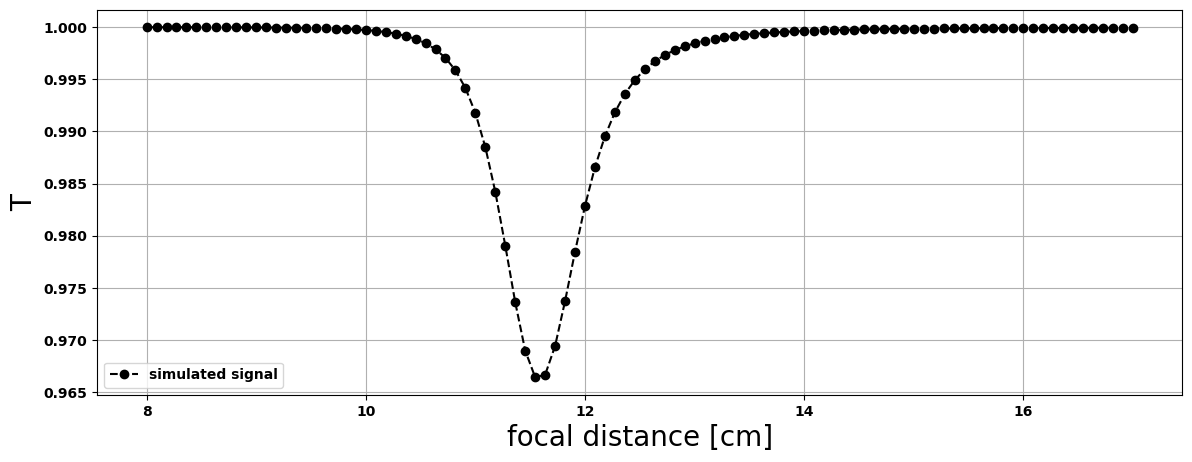

In [3]:
fig=plt.figure(figsize=(14,5))

######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal_e = 1e-2*np.linspace(8,17,100) #focal distance [m]
beta_e = 3.4e-11 # TPA seed in (m/W )
L_e = 1e-3 # thickness in (m).
Pavg_e  = 200e-3# Average power in (W)
Tp_e  = 200e-15 # pulse width FWHM in (s)
wl_e  = 790e-9 #central wavelength in (m)
D_e  = 2e-3 # beam diameter in (m)
ds_e  = 116e-3# Distance EFTL-sample (m)a
Cf_e  = 1.36 # beam correction coeff
alfa_e =2.6e-1 # linear absorption in (1/m) 
R_e  = 0.33 # reflection percentage 
freq_e  = 90.6e6 #Frecuencia en HZ
trans_e=list(fscanTH2(focal_e ,beta_e ,L_e ,Pavg_e ,Tp_e ,wl_e ,D_e ,ds_e ,Cf_e ,alfa_e ,R_e ,freq_e )) #Señal simulada
val_min=min(trans_e)
index=trans_e.index(min(trans_e))
#Td= np.gradient(T)


plt.plot(focal_e *100,trans_e,'--ko',label='simulated signal')
#plt.plot(corriente,Td,'--ro',label='derivada')
plt.ylabel('T',fontsize=20)
plt.xlabel('focal distance [cm]',fontsize=20)
plt.legend()
plt.grid()






# Method 1.


In [4]:
T, f,L,P,Tp,wl,D,ds,Cf,alfa,R,freq = sym.symbols('T f L P Tp wl D ds Cf alfa R freq')
params=[T, f,L,P,Tp,wl,D,ds,Cf,alfa,R,freq]

# Función ajustar
def BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - sym.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(sym.pi*D) # beam waist
    z0 = sym.pi*w0**2/wl # Rayleigh range
    w = w0*sym.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*sym.sqrt(sym.log(2))*Pavg/(Tp*freq*sym.pi**1.5*w**2) # Peak intensity at sample
    b=(1-trans)*(1/(2*sym.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def BETA_prime(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq,param):
    return sym.diff(BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq),param,1)


#print(BETA_prime(T,f,L,P,Tp,wl,D,ds,Cf,alfa,R,freq,params[0])) #This works.

DerivativeOfF = sym.lambdify((T, f,L,P,Tp,wl,D,ds,Cf,alfa,R,freq),BETA_prime(T, f,L,P,Tp,wl,D,ds,Cf,alfa,R,freq,params[0]),"numpy")

#print(DerivativeOfF(1,1,1))

# Separate effect.

For method 1 the error propagation formula tells us:

$$\sigma^{2}=\left(\frac{\partial \beta}{\partial x} \sigma_{X}\right)^{2}+\left(\frac{\partial \beta}{\partial y} \sigma_{Y}\right)^{2}+\sum_{i=1}^{N}\left(\frac{\partial \beta}{\partial v_i} \sigma_{V_i}\right)^{2}$$


We calculate the derivatives separately:

In [5]:
results=[]

for i in range(0,12):
    DerivativeOfF = sym.lambdify((T, f,L,P,Tp,wl,D,ds,Cf,alfa,R,freq),BETA_prime(T, f,L,P,Tp,wl,D,ds,Cf,alfa,R,freq,params[i]),"numpy")
    val=DerivativeOfF(trans_e[index],focal_e[index],L_e,Pavg_e,Tp_e,wl_e,D_e,ds_e,Cf_e,alfa_e,R_e,freq_e)
    results.append(abs(val))

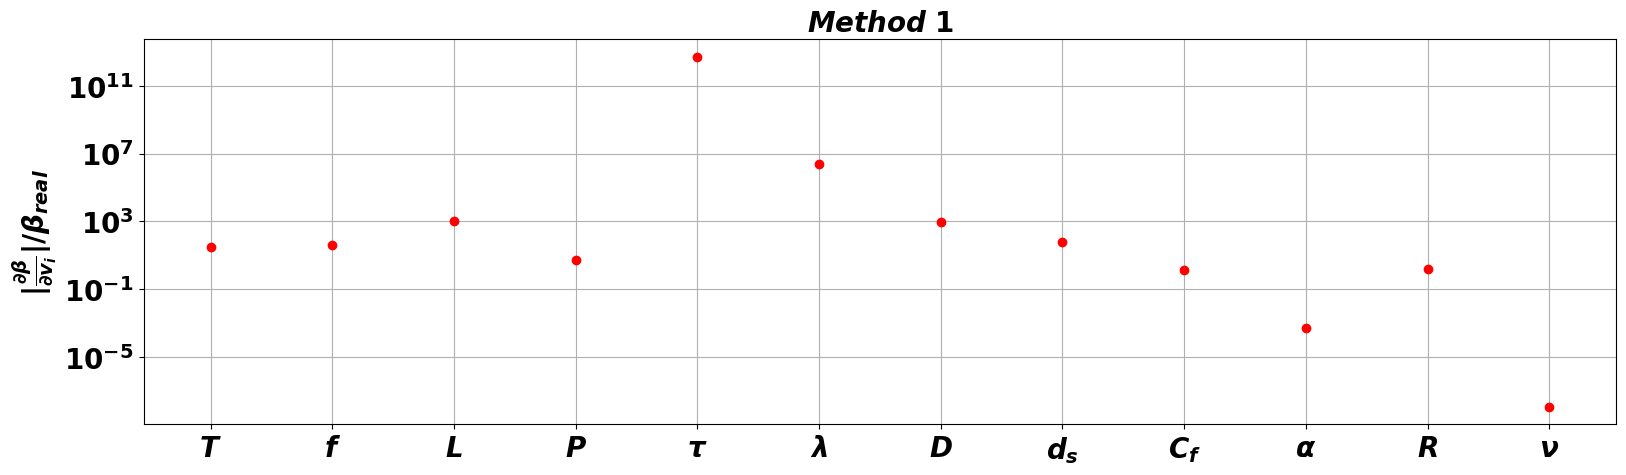

In [8]:
reals=[trans_e[index],trans_e[index],focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,Cf_e,alfa_e,R_e,freq_e]
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
l=[r'$T$',r'$f$',r'$L$',r'$P$',r'$\tau$',r'$\lambda$',r'$D$',r'$d_s$',r'$C_f$',r'$\alpha$',r'$R$',r'$\nu$']
p_max=[i/beta_e  for c,i in enumerate(results)]  # cota maxima
sum_max=np.sqrt(sum(i**2 for i in p_max)) 
f=plt.figure(figsize=(19,5))
plt.grid(True, which="both")
plt.semilogy(l,p_max,'ro')#label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | /\beta_{real}$')
plt.ylabel(r'$\left | \frac{\partial \beta}{\partial v_i} \right |  /\beta_{real}$',fontsize=20)
plt.title('$Method$ $1$',fontsize=20)
plt.show()


# Method 2.

$$\sigma^{2}=\sum_{l=1}^{n}\left(\frac{\partial \beta}{\partial x_l} \sigma_{X_l}\right)^{2}+\sum_{l=1}^{n}\left(\frac{\partial \beta}{\partial y_l} \sigma_{Y_l}\right)^{2}+\sum_{i=1}^{N}\left(\frac{\partial \beta}{\partial v_i} \sigma_{V_i}\right)^{2}$$

In [13]:
y_as_strings = ['T'+str(i) for i in range(len(trans_e))]
f_as_strings = ['f'+str(i) for i in range(len(trans_e))]
y_as_symbol_objects = [sym.symbols(v) for v  in y_as_strings] # Simbolos para y
f_as_symbol_objects = [sym.symbols(v) for v  in f_as_strings] # Simbolos para f
 
def BETA2(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - sym.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(sym.pi*D) # beam waist
    z0 = sym.pi*w0**2/wl # Rayleigh range
    w = w0*(1 + ((ds - focal)/z0)**2)**0.5 # Beam radius
    I0 = 4*(np.log(2))**0.5*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*(2)**0.5)*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def BETA_prime(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq,param):
    return sym.diff(BETA2(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq),param,1)

y_as_symbol_objects=np.array(y_as_symbol_objects)
f_as_symbol_objects=np.array(f_as_symbol_objects)

In [14]:
er=np.linspace(0.005,10,50)/100
results1=[]
results2=[]
results3=[]

for i in range(len(trans_e)):
    
    DerivativeOfF = sym.lambdify((y_as_symbol_objects,f_as_symbol_objects,L,P,Tp,wl,D,ds,Cf,alfa,R,freq),BETA_prime(y_as_symbol_objects, f_as_symbol_objects,L,P,Tp,wl,D,ds,Cf,alfa,R,freq,y_as_symbol_objects[i]),"numpy")
    val=DerivativeOfF(trans_e,focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,ds_e,Cf_e,alfa_e,R_e,freq_e)
    results1.append(abs(val))


for i in range(len(trans_e)):
    
    DerivativeOfF = sym.lambdify((y_as_symbol_objects,f_as_symbol_objects,L,P,Tp,wl,D,ds,Cf,alfa,R,freq),BETA_prime(y_as_symbol_objects, f_as_symbol_objects,L,P,Tp,wl,D,ds,Cf,alfa,R,freq,y_as_symbol_objects[i]),"numpy")
    val=DerivativeOfF(trans_e,focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,ds_e,Cf_e,alfa_e,R_e,freq_e)
    results2.append(abs(val))


for i in range(2,12):
    
    DerivativeOfF = sym.lambdify((y_as_symbol_objects,f_as_symbol_objects,L,P,Tp,wl,D,ds,Cf,alfa,R,freq),BETA_prime(y_as_symbol_objects, f_as_symbol_objects,L,P,Tp,wl,D,ds,Cf,alfa,R,freq,params[i]),"numpy")
    val=DerivativeOfF(trans_e,focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,ds_e,Cf_e,alfa_e,R_e,freq_e)
    results3.append(abs(val))

In [10]:
term1=results1
reals=[trans_e,focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,ds_e,Cf_e,alfa_e,R_e,freq_e]
p_min1=[i*0.005/(1.96*100)*reals[1][c]/beta for c,i in enumerate(term1)]
p_max1=[i*10/100*reals[1][c]*1e11 for c,i in enumerate(term1)]
sum_min1=np.sqrt(sum(i**2 for i in p_min1))
sum_max1=np.sqrt(sum(i**2 for i in p_max1))

In [11]:
term2=results2
reals=[trans_e,focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,ds_e,Cf_e,alfa_e,R_e,freq_e]
p_min2=[i*0.005/100*reals[0][c]*1e11 for c,i in enumerate(term2)]
p_max2=[i*10/100*reals[1][c]*1e11 for c,i in enumerate(term2)]
sum_min2=np.sqrt(sum(i**2 for i in p_min2))
sum_max2=np.sqrt(sum(i**2 for i in p_max2))

In [12]:
term3=results3
reals=[L_e,Pavg_e,Tp_e,wl_e,D_e,ds_e,Cf_e,alfa_e,R_e,freq_e]
p_min3=[i*0.005/100*reals[c]*1e11 for c,i in enumerate(term3)]
p_max3=[i*10/100*reals[c]*1e11 for c,i in enumerate(term3)]
sum_min3=np.sqrt(sum(i**2 for i in p_min3))
sum_max3=np.sqrt(sum(i**2 for i in p_max3))

In [25]:
l=[r'$1$',r'$2$',r'$L$',r'$P$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$Cf$',r'$\alpha$',r'$R$',r'$\nu$']

In [18]:
fin_min=[sum_min1]+[sum_min2]+p_min3
fin_max=[sum_max1]+[sum_max2]+p_max3

Text(0, 0.5, '$\\left | \\frac{\\partial \\beta}{\\partial v_i} \\right | \\sigma_{v_i}$')

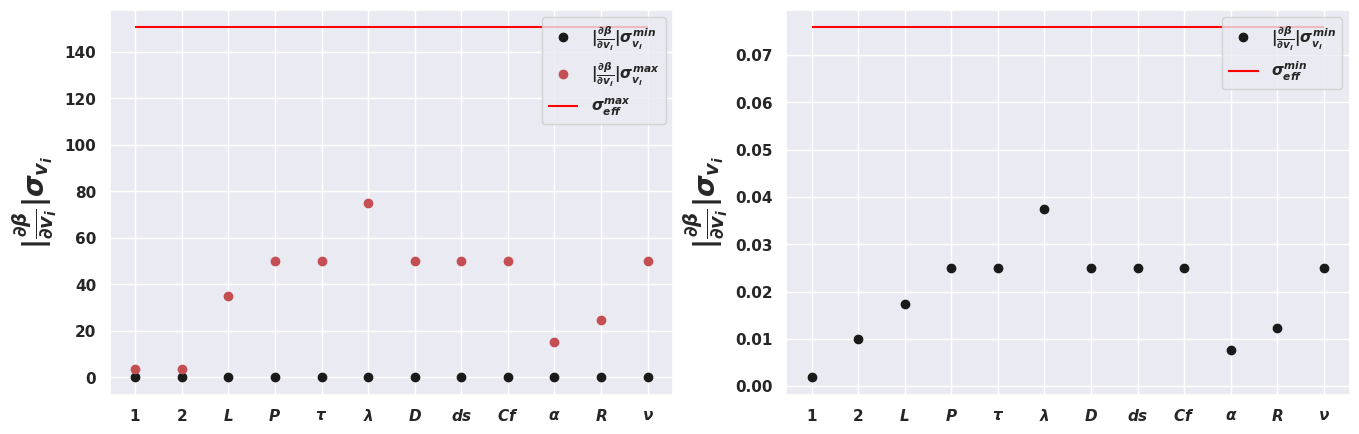

In [26]:
#plt.plot(l,results,'ko')

sum_min1=(sum(i**2 for i in p_min1))
sum_max1=(sum(i**2 for i in p_max1))
sum_min2=(sum(i**2 for i in p_min2))
sum_max2=(sum(i**2 for i in p_max2))
sum_min3=(sum(i**2 for i in p_min3))
sum_max3=(sum(i**2 for i in p_max3))

f=plt.figure(figsize=(16,5))

plt.subplot(121)
plt.plot(l,fin_min,'ko',label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma^{min}_{v_i}$')
plt.plot(l,fin_max,'ro',label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma^{max}_{v_i}$')
plt.hlines(np.sqrt(sum_max1+sum_max2+sum_max3),xmin=l[0],xmax=l[-1],color='red',label='$\sigma^{max}_{eff}$')
#plt.hlines(sum_max,xmin=l[0],xmax=l[-1],color='red',label='$\sigma^{max}_{eff}$')
plt.legend()
plt.ylabel(r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma_{v_i}$',fontsize=20)

plt.subplot(122)
plt.plot(l,fin_min,'ko',label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma^{min}_{v_i}$')
#lt.hlines(sum_max,xmin=l[0],xmax=l[-1],color='red',label='$\sigma^{max}_{eff}$')
plt.hlines(np.sqrt(sum_min1+sum_min2+sum_min3),xmin=l[0],xmax=l[-1],color='red',label='$\sigma^{min}_{eff}$')
#plt.plot(l,fin_max,'ro',label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma^{max}_{v_i}$')
#plt.hlines(sum_max,xmin=l[0],xmax=l[-1],color='red',label='$\sigma^{max}_{eff}$')
plt.legend()
plt.ylabel(r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma_{v_i}$',fontsize=20)




In [ ]:

plt.subplot(122)
plt.plot(l,p_min,'ko',label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma^{min}_{v_i}$')
plt.hlines(sum_min,xmin=l[0],xmax=l[-1],color='red',label='$\sigma^{min}_{eff}$')
plt.legend()
plt.ylabel(r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma_{v_i}$',fontsize=20)